In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset, 64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 64, shuffle=False)


In [ ]:
class Model(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes):

        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)

        self.fc = nn.Linear(hidden_size, num_classes)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

    def forward(self, X:torch.Tensor):

        h0 = torch.zeros((self.num_layers, X.shape[0], self.hidden_size)).to(device)
        c0 = torch.zeros((self.num_layers, X.shape[0], self.hidden_size)).to(device)

        out, (hn, cn) = self.lstm(X, (h0, c0))
        #out.shape = (batches, seq_len, hidden_size)

        out = out[:, -1, :] #taking only the output of last LSTM-Cell for each input of the batch
        #out.shape = (batches, hidden_size)

        out = self.fc(out)
        
        
        return out


        

In [4]:
model = Model(28, 28, 3, 10).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

In [ ]:
for epoch in range(2):
    for iteration, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (iteration+1)%100==0:
            print (f'Epoch [{epoch+1}], Step [{iteration+1}], Loss: {loss.item():.4f}')


with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28, 28).to(device)
        labels = labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predicted==labels).sum().item()
    
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')
        

In [15]:
x = torch.arange(10).reshape(2, 5)

x.data

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [5]:
class AE(nn.Module):

    def __init__(self, in_features, embedding_dim):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.Sigmoid(),
            nn.Linear(256, embedding_dim),
            nn.Sigmoid(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.Sigmoid(),
            nn.Linear(256, in_features),
            nn.Sigmoid()
        )
    
    def forward(self, X):

        out = self.encoder(X)
        out = self.decoder(out)

        return out
    
    def get_embedding(self, X):
        
        out = self.encoder(X)
        return out
    


In [6]:
model = AE(784, 128).to(device)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters())

In [ ]:
for epoch in range(0):
    for iteration, (images, labels) in enumerate(train_loader):

        images = torch.flatten(images, 1).to(device)
        # labels = labels.to(device)

        output = model(images)
        loss = criterion(output, images)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (iteration+1)%200==0:
            print (f'Epoch [{epoch+1}], Step [{iteration+1}], Loss: {loss.item():.5f}')


with torch.no_grad():

    n_samples = 0
    loss = 0.

    max_loss = 0.

    for images, labels in test_loader:
        
        images = torch.flatten(images, 1).to(device)

        output = model(images)

        batch_loss = criterion(output, images)
        max_loss = max(batch_loss, max_loss)
        batch_loss *= images.shape[0]

        loss += batch_loss
        n_samples += images.shape[0]

    print(f"final loss: {loss/n_samples}")
    print(f"max loss: {max_loss}")




final loss: 0.006270756479352713
max loss: 0.03525340184569359


In [7]:
x = torch.rand(1, 784).to(device)
out = model(x)

criterion(out, x)

tensor(0.0888, device='cuda:0', grad_fn=<MseLossBackward0>)

In [8]:
torch.flatten(x, 0, 1).shape

torch.Size([784])

In [ ]:
img = next(iter(test_loader))[0].flatten(0, 2)

# plt.imshow(img, cmap='grey')

new = torch.clip(img + torch.rand((28, 28))*0.5-0.1, 0., 1.)

# plt.imshow(new, cmap='grey')

output = model(new.reshape((1, 784)).to(device)).to('cpu').detach().reshape((28, 28))
# plt.imshow(output, cmap='grey')

fig, ax = plt.subplots(1, 3)

ax[0].imshow(img, cmap='grey')
ax[2].imshow(output, cmap='grey')
ax[1].imshow(new, cmap='grey')

$        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}$

In [80]:
class VAE(nn.Module):

    def __init__(self, input_dim, hidden_dim=256, latent_dim=64):

        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)


    def encode(self, X):
        out = self.encoder(X)

        mu = self.fc_mu(out)
        log_var = self.fc_log_var(out)
        return (mu, log_var)
    
    def reparameterization(self, mu, std):
        
        epsilon = torch.randn_like(mu).to(mu.device)
        z = mu + epsilon * std
        return z
    
    def decode(self, Z):

        out = self.decoder(Z)
        return out
    

    def forward(self, X):
        mu, log_var = self.encode(X)
        z = self.reparameterization(mu, torch.exp(0.5 * log_var))
        out = self.decode(z)
        return (out, mu, log_var)
    

    def get_loss(self, output, input):
        out, mu, log_var = output

        recon_loss = F.binary_cross_entropy(out, input, reduction='sum')/input.shape[0]
        kld_loss = -0.5 * torch.sum(1+log_var - mu**2 - log_var.exp()) /input.shape[0] 

        print("kld_loss= ", kld_loss)
        print(recon_loss)
        return recon_loss + kld_loss


In [77]:
x = torch.rand((2, 3))
x_hat = torch.rand((2, 3))

t1 = (x*torch.log(x_hat) + (1-x)*torch.log(1-x_hat)).sum(-1).mean()

t2 = F.binary_cross_entropy(x_hat, x, reduction='sum')/x.shape[0]

print(t1)
print(t2)

tensor(-5.0714)
tensor(5.0714)


In [81]:
model = VAE(784, latent_dim=16).to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [82]:
for epoch in range(10):
    for iteration, (images, labels) in enumerate(train_loader):

        images = torch.flatten(images, 1).to(device)
        # labels = labels.to(device)

        output = model(images)
        loss = model.get_loss(output, images)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (iteration+1)%200==0:
            print (f'Epoch [{epoch+1}], Step [{iteration+1}], Loss: {loss.item():.5f}')


with torch.no_grad():

    n_samples = 0
    loss = 0.

    max_loss = 0.

    for images, labels in test_loader:
        
        images = torch.flatten(images, 1).to(device)

        output = model(images)

        batch_loss = model.get_loss(output, images)
        max_loss = max(batch_loss, max_loss)
        batch_loss *= images.shape[0]

        loss += batch_loss
        n_samples += images.shape[0]

    print(f"final loss: {loss/n_samples}")
    print(f"max loss: {max_loss}")




kld_loss=  tensor(0.0914, device='cuda:0', grad_fn=<DivBackward0>)
tensor(550.8013, device='cuda:0', grad_fn=<DivBackward0>)
kld_loss=  tensor(0.0800, device='cuda:0', grad_fn=<DivBackward0>)
tensor(545.7042, device='cuda:0', grad_fn=<DivBackward0>)
kld_loss=  tensor(0.0953, device='cuda:0', grad_fn=<DivBackward0>)
tensor(540.3759, device='cuda:0', grad_fn=<DivBackward0>)
kld_loss=  tensor(0.1053, device='cuda:0', grad_fn=<DivBackward0>)
tensor(535.0623, device='cuda:0', grad_fn=<DivBackward0>)
kld_loss=  tensor(0.1305, device='cuda:0', grad_fn=<DivBackward0>)
tensor(529.2766, device='cuda:0', grad_fn=<DivBackward0>)
kld_loss=  tensor(0.1731, device='cuda:0', grad_fn=<DivBackward0>)
tensor(523.7797, device='cuda:0', grad_fn=<DivBackward0>)
kld_loss=  tensor(0.2067, device='cuda:0', grad_fn=<DivBackward0>)
tensor(518.6741, device='cuda:0', grad_fn=<DivBackward0>)
kld_loss=  tensor(0.2579, device='cuda:0', grad_fn=<DivBackward0>)
tensor(513.4090, device='cuda:0', grad_fn=<DivBackward0>)


KeyboardInterrupt: 

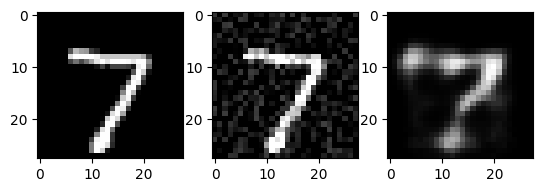

In [67]:
img = next(iter(test_loader))[0][0][0]
# plt.imshow(img, cmap='grey')



new = torch.clip(img + torch.rand((28, 28))*0.5-0.25, 0., 1.).to(device)
# new = img.to(device)

# plt.imshow(new, cmap='grey')

output, _, _ = model(new.reshape((1, 784)))
output = output.to('cpu').detach().reshape((28, 28))
# plt.imshow(output, cmap='grey')

fig, ax = plt.subplots(1, 3)

ax[0].imshow(img, cmap='grey')
ax[2].imshow(output, cmap='grey')
ax[1].imshow(new.cpu(), cmap='grey')

In [70]:
img = torch.rand((1, 784)).to(device)
out = model(img)

print(model.get_loss(out, img))


tensor(2691.1125, device='cuda:0', grad_fn=<AddBackward0>)


In [73]:
img = next(iter(test_loader))[0][0][0].to(device).reshape((1, 784))
out = model(img)

print(model.get_loss(out, img))

tensor(87.3029, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
nums = [
    3.5259535025033983e-07,
4.0165105019696057e-07,
3.533048129611416e-07,
3.3367618357260653e-07,
4.83686108054826e-07,
6.247730652830796e-07,
3.894396911618969e-07,
5.071929081168491e-07,
2.7539059033188096e-07,
4.3725191289922805e-07,
3.513985120662255e-07,
2.710195872168697e-07,
4.046019910219911e-07,
5.764940169683541e-07,
3.8089086729087285e-07,
5.026249709771946e-07,
3.6678591186500853e-07,
5.301873216012609e-07,
3.908228904947464e-07,
3.389492917449388e-07,
3.520082714203454e-07,
4.186566116004542e-07,
4.905000423605088e-07,
3.402763297799538e-07,
4.212470230413601e-07,
3.368982959273126e-07,
2.9577540772152133e-07,
4.4898470719090255e-07,
2.59350770193123e-07,
5.211195457377471e-07,
3.536773647283553e-07,
3.940897386200959e-07,
4.5967368578203605e-07,
6.922647912688262e-07,
5.97378289057815e-07,
7.757926141493954e-07,
4.385973397802445e-07,
4.4935552523384104e-07,
5.188309728509921e-07,
3.473062122338888e-07,
3.4980490681846277e-07,
4.460411560103239e-07,
3.253090028465522e-07,
5.540416054827801e-07,
4.0904427578425384e-07,
4.217735067868489e-07,
4.0269867440656526e-07,
3.7794728768858477e-07,
4.3611072442217846e-07,
3.76650575617532e-07,
6.28968223281845e-07,
2.7349207698534883e-07,
3.3899866025421943e-07,
4.1224842561859987e-07,
3.199218383542757e-07,
]

count = 0
for i in nums:
    if (i>4.0e-7):
        count += 1
    
print(f"Predicted wrongly - {count}/{len(nums)}")

In [10]:
from math import ceil
import os, random, json


random.seed(0)



test_paths = []
train_paths = []





for i in range(1, 5):

    with open(f"video{i}_kill_timestamps.txt") as f:
        lines = f.readlines()

    
    lines = [t[:-1] for t in lines]
    lines = [t.split(':') for t in lines]
    lines = [int(t[0])*60+int(t[1]) for t in lines]

    lines = [f"data/video4_{t-2}_{t+1}.mp4" for t in lines]

    test_paths_i = random.sample(lines, k=ceil(len(lines)*0.2))
    train_paths_i = [i for i in lines if i not in test_paths_i]

    test_paths += test_paths_i
    train_paths += train_paths_i




paths = {
    'train':train_paths,
    'test':test_paths
}

print(len(train_paths))
print(len(test_paths))

with open("train_test_clips.json", 'w') as f:
    json.dump(paths, f, indent=2)

118
30
